# Quantization


# The picture we work with:

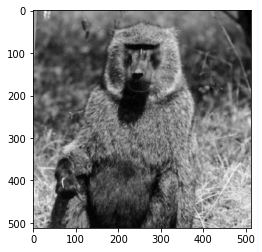

In [34]:
#@title
import numpy as np
import cv2
import os
from skimage import io,color
import math

# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
# from google.colab import files
# from IPython.display import Image

image = io.imread("/content/Monkey.gif")
plt.imshow(image+3.9, cmap='gray')
plt.show()

#1. Histogram of gray levels.
We created a histogram of gray levels and normalised it to get the PDF of the image gray levels

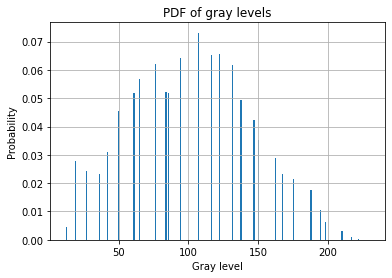

In [35]:
#@title
# Estimate the pdf of gray level in the image
counts, bins = np.histogram(image, bins=256)
counts = counts / sum(counts)
plt.hist(bins[:-1], bins, weights=counts);
plt.title('PDF of gray levels')
plt.xlabel('Gray level')
plt.ylabel('Probability')
plt.grid()
pdf = [counts[i] for i in range(bins.shape[0]-1)]


#2. We applied uniform quantization on the image for b bits (b from 1 to 8)
#a. 
MSE as function of b (bits per pixel)
we the MSE is high when the bit budget is hight and converges to zero quickly as bit budget gets bigger.

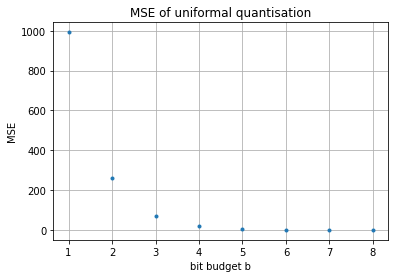

In [36]:
#@title
def mse(image, q_image):
  """
  Calculates the MSE for given image and its comparison
  """
  return sum(sum((image - q_image)**2)) / (image.shape[0]*image.shape[1])

def mad(image1,image2):
  '''
  Calculated the MAD for given image and its comparison.
  '''
  return sum(sum(abs(image1-image2)))/(image1.shape[0]*image1.shape[1])

def quantisize(image, b):
  num_levels = 2**b
  min = image.min()
  max = image.max()
  I_length=max-min
  dx=I_length/num_levels
  q_image = image.min() + (np.floor((image-image.min())/dx)+1/2)*dx
  return q_image
  
mse_values = [mse(image, quantisize(image, b+1)) for b in range(8)];
plt.plot(np.array(range(1,9)), mse_values, '.')
plt.title('MSE of uniformal quantisation')
plt.xlabel('bit budget b')
plt.ylabel('MSE')
plt.grid()

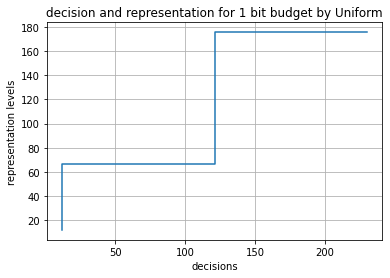

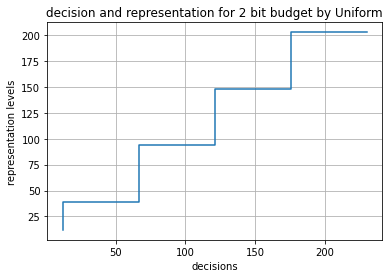

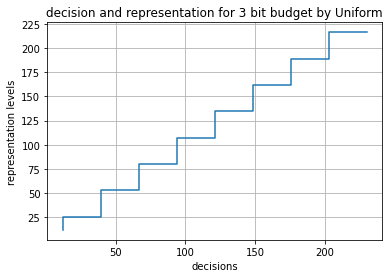

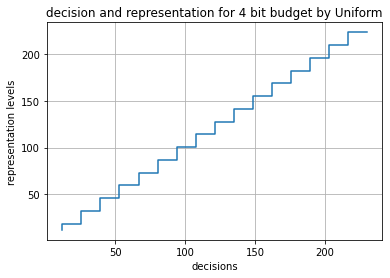

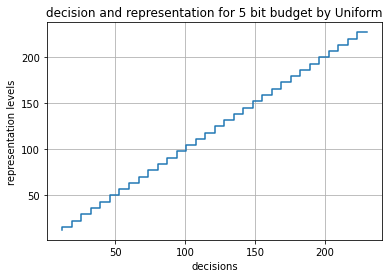

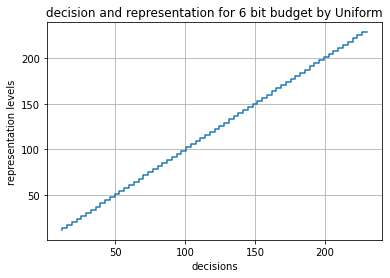

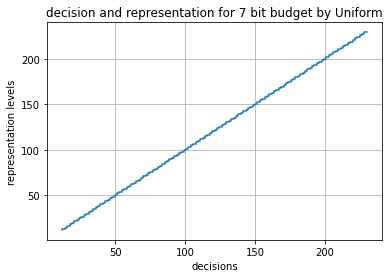

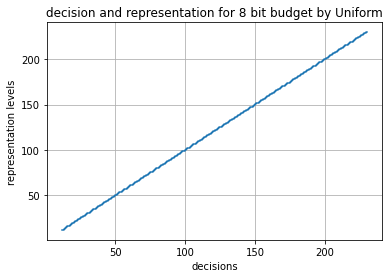

In [37]:
#@title
def plot_decision_and_representation(image, b):
  min_val = np.min(image)
  max_val = np.max(image)
  k = 2 ** b
  delta = (max_val - min_val)/k
  decisions = [min_val + i*delta for i in range(k+1)]
  r_values = [min_val + (i-0.5)*delta for i in range(1,k+1)]
  r_values = [min_val] + r_values
  plt.figure()
  plt.step(decisions, r_values)
  plt.title(f'decision and representation for {b} bit budget by Uniform')
  plt.xlabel('decisions')
  plt.ylabel('representation levels')
  plt.grid()
for b in range(1,9):
  plot_decision_and_representation(image, b)

#3
Max-Lloyd algorithm implementation is shown in the code.

In [38]:
#@title
from bisect import bisect

def get_q_image(image,d,r):
  """
  Given the original image and the representation and decision levels,
  Returns the quantisized image.
  """
  qu_image = np.zeros(image.shape)
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      pix_value = image[i][j]
      d_ind = bisect(d, pix_value)
      if d_ind-1== len(r):
        d_ind-=1
      qu_image[i][j] = r[d_ind-1]
  return qu_image

def max_lloyd_single_step(pdf,initial_d):
  """
  Single step of max-lloyd.
  Given pdf and initial decision return the next representation and decision levels.
  """
  Intervals = [ (initial_d[i],initial_d[i+1]) for i in range(len(initial_d)-1)]
  first_moment=[x*pdf[x] for x in range(len(pdf))]
  r= [ sum(first_moment[int(I[0]):int(I[1])])/sum(pdf[int(I[0]):int(I[1])]) if sum(pdf[int(I[0]):int(I[1])])!=0 else (int(I[0])+int(I[1]))/2  for I in Intervals]
  d = [(r[i-1]+r[i])/2 for i in range(1, len(initial_d)-1)]
  d = [initial_d[0], *d , initial_d[-1]]
  return d,r

def max_lloyd(image, pdf,initial_d,epsilon):
  """
  Max lloyd algorithm
  Gets image, PDF, initial decision level and epsilon (stop condition, When the MSE improve less than epsilon in the iteration we stop the algorithm). 
  Returns the optimal decision and representation levels.
  """
  d=initial_d
  d, r = max_lloyd_single_step(pdf,d)
  qu_image = get_q_image(image,d,r)
  old_mse = mse(image, qu_image)
  while True:
     new_d,new_r = max_lloyd_single_step(pdf, d)
     quu_image = get_q_image(image,new_d,new_r)
     new_mse = mse(image, quu_image)
     delt = old_mse-new_mse
     if (delt<epsilon):
       break
     old_mse = new_mse
     d = new_d
     r = new_r
  return d, r



#4
##a.
Showing the mse as a function of the bit-budget b for b in {1,...,8}.
Like in the uniform case, start with high mse and gets lower with the increase of the bit budget.

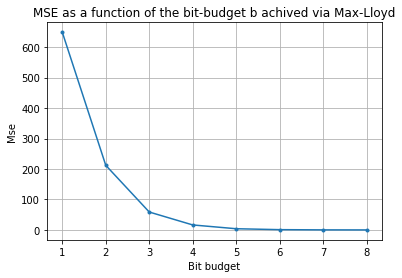

In [39]:
#@title
d=[]
r=[]
b_max= 8
for b in range(1,b_max+1):
  initial_d = np.linspace(np.min(image),np.max(image),2**b+1)
  epsilon = 2
  d_iter,r_iter = max_lloyd(image, pdf, initial_d, epsilon)
  d.append(d_iter)
  r.append(r_iter)
q_images = [get_q_image(image,d[i],r[i]) for i in range(b_max)]
mse_arr = [mse(image,q_images[i]) for i in range(b_max)]

plt.figure()
plt.plot(list(range(1,9)),mse_arr,marker='.')
plt.title(f'MSE as a function of the bit-budget b achived via Max-Lloyd')
plt.xlabel('Bit budget')
plt.ylabel('Mse')
plt.grid()

##b.
Ploting the decision and representation levels for b in {1,2,4,7,8} drawn as step functions.

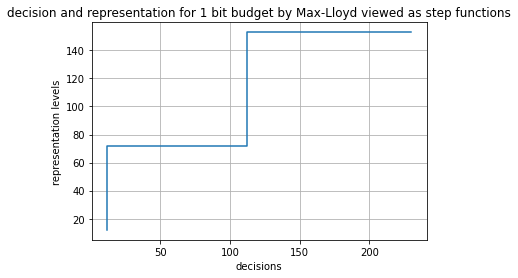

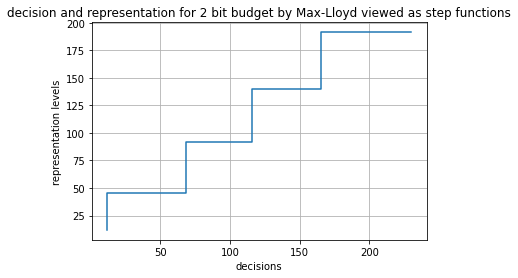

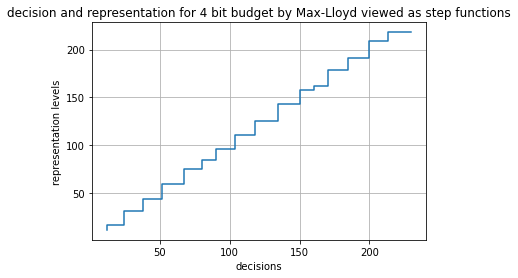

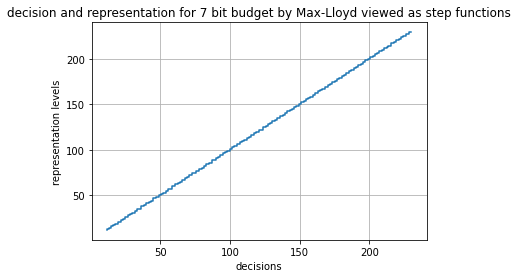

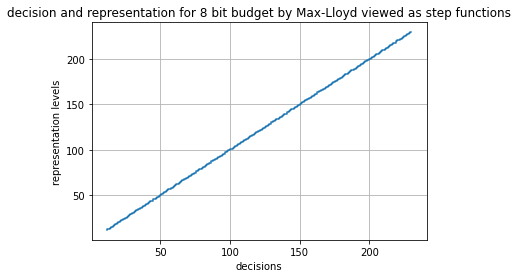

In [40]:
#@title
for i in [1,2,4,7,8]:
  plt.figure()
  plt.step(d[i-1], [image.min()]+r[i-1])
  plt.title(f'decision and representation for {i} bit budget by Max-Lloyd viewed as step functions')
  plt.xlabel('decisions')
  plt.ylabel('representation levels')
  plt.grid()
  plt.show()

##c.
Comparing the results we get:

Putting the resultant images from each algorithm for different bit values we can see a noticable difference for low bit budget but for higher the difference is very slight.

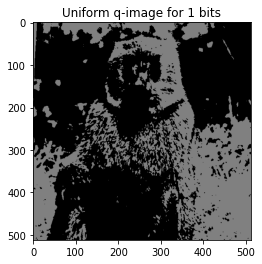

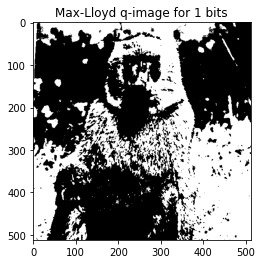

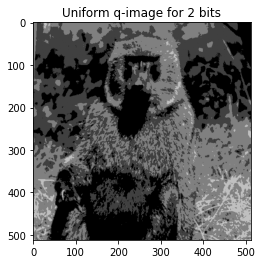

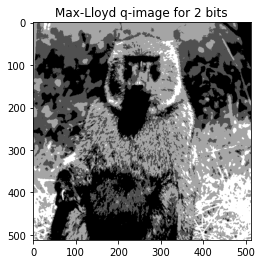

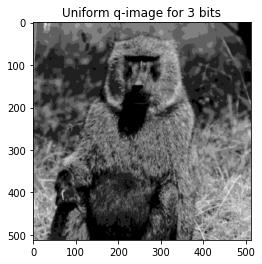

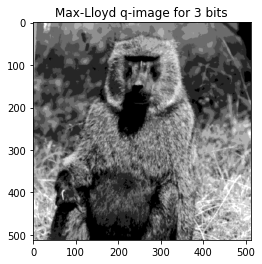

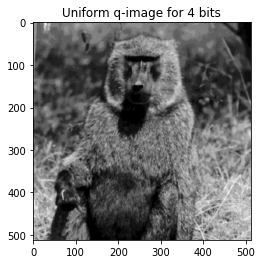

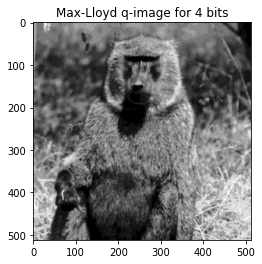

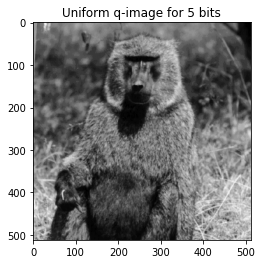

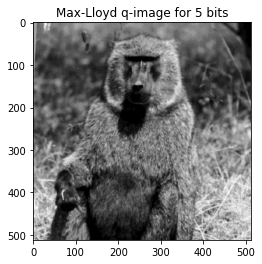

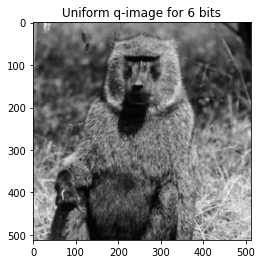

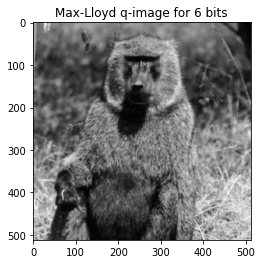

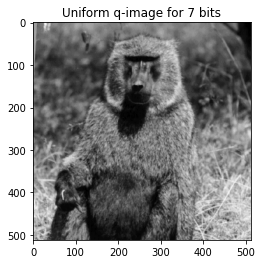

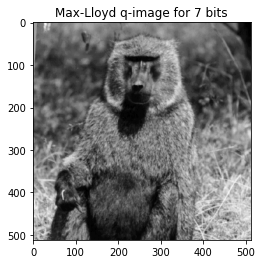

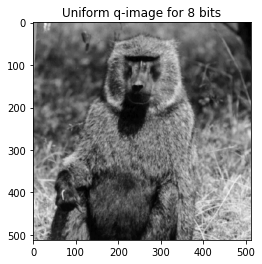

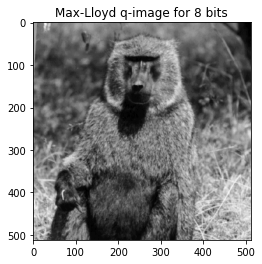

In [41]:
#@title
mse_uniform = []
mse_maxlloyd = []
for b in range(1,9):
  # Uniform:
  uni_q_image = quantisize(image, b)
  plt.imshow(uni_q_image, cmap='gray')
  plt.title(f'Uniform q-image for {b} bits')
  plt.show()
  mse_uniform.append(mse(image, uni_q_image))
  # Max-Lloyd:
  ml_q_image = q_images[b-1]
  plt.imshow(ml_q_image, cmap='gray')
  plt.title(f'Max-Lloyd q-image for {b} bits')
  plt.show()
  mse_maxlloyd.append(mse(image, ml_q_image))

To do the MSEs comperision we put the mse-bit graphs of both methods on the same graph and plot them together.
We can clearly see Max-Lloyd algorithm gives slightly better (lower) MSE results, which is noticable when the bit budget is low and less noticable when it is high.

Both of the methods converged to same value -> 0.

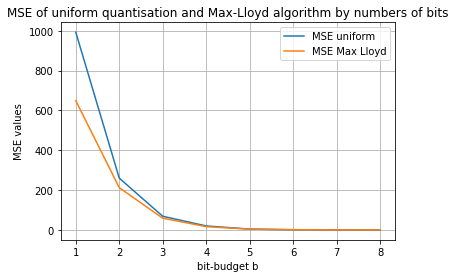

In [42]:
#@title
#plot MSEs:
bs = range(1,9)
plt.figure()
plt.plot(bs, mse_uniform, label='MSE uniform')
plt.plot(bs, mse_maxlloyd, label='MSE Max Lloyd')
plt.legend()
plt.title('MSE of uniform quantisation and Max-Lloyd algorithm by numbers of bits')
plt.grid()
plt.xlabel('bit-budget b')
plt.ylabel('MSE values')
plt.show()

#Q2  Subsampling and Reconstruction
##1

In [43]:
#@title
def subsample_image(image,b,method):
  D=2**b
  x_size=image.shape[0]
  y_size=image.shape[1]
  dx=int(x_size/D)
  dy=int(y_size/D)
  
  #breakpoint()
  s_image=np.zeros((D,D))
  for i in range(D):
    for j in range(D):
      if (method == "mse"):
        s_image[i][j]=sum(sum(image[i*dx:(i+1)*dx,j*dy:(j+1)*dy]))/(dx*dy)
      if (method == "mad"):
        s_image[i][j]=np.median(image[i*dx:(i+1)*dx,j*dy:(j+1)*dy]) 
  return s_image

def enlarge_image(image,x_factor,y_factor):
  x_size=int(image.shape[0]*x_factor)
  y_size=int(image.shape[0]*y_factor)
  I_image=np.zeros((x_size,y_size))
  for i in range(x_size):
    for j in range(y_size):
      I_image[i][j]=image[int(i//x_factor)][int(j//y_factor)]
  return I_image

subsambpled_images_mse_arr = [subsample_image(image,b,"mse") for b in range(1,9)]
subsambpled_images_mad_arr= [subsample_image(image,b,"mad") for b in range(1,9)]
x_size=image.shape[0]
y_size=image.shape[1]

reconstructed_images_mse = [enlarge_image(subsambpled_images_mse_arr[b-1],x_size/(2**b),y_size/(2**b)) for b in range(1,9)]
reconstructed_images_mad = [enlarge_image(subsambpled_images_mad_arr[b-1],x_size/(2**b),y_size/(2**b)) for b in range(1,9)]
mse_arr = [mse(reconstructed_images_mse[b-1],image) for b in range(1,9)]
mad_arr = [mad(reconstructed_images_mse[b-1],image) for b in range(1,9)]


##a.
Showing the MSE as a finction of the integer sub-sampling factor D we can see the MSE decrease as the sub-sampling factor increases.

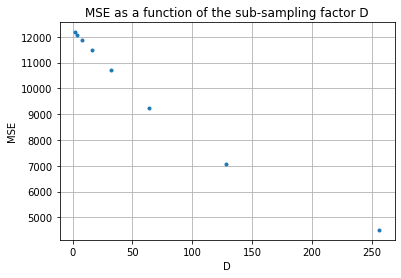

In [44]:
#@title
plt.plot(2**np.array(range(1,9)), mse_arr, '.')
plt.title('MSE as a function of the sub-sampling factor D')
plt.xlabel('D')
plt.ylabel('MSE')
plt.grid()
plt.show()

##b.
Showing the MAD as a function of the integer sub-sampling factor D we can see the MAD decrease as the sub-sampling factor increases.

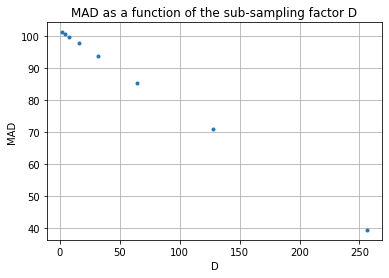

In [45]:
#@title
plt.plot(2**np.array(range(1,9)), mad_arr, '.')
plt.title('MAD as a function of the sub-sampling factor D')
plt.xlabel('D')
plt.ylabel('MAD')
plt.grid()
plt.show()

#2
When reconstructing the images of the MSE and MAD for all D's we see that the reconstructed images look similar to the original image as D increases.

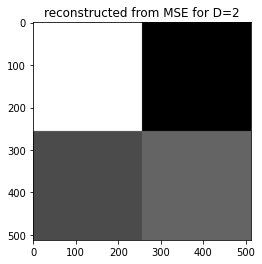

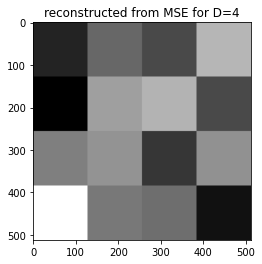

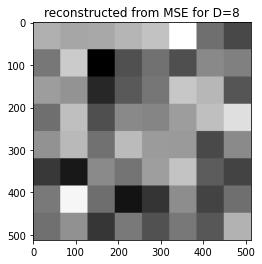

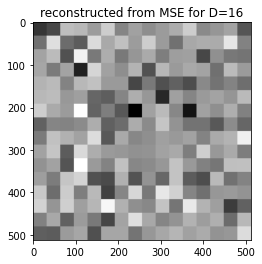

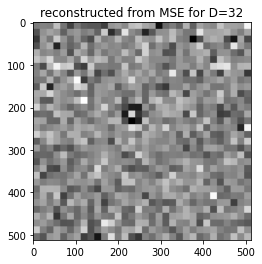

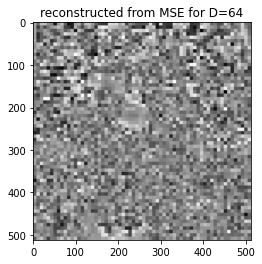

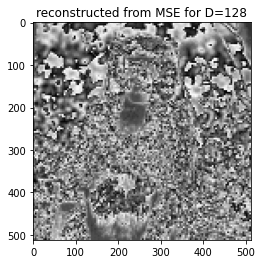

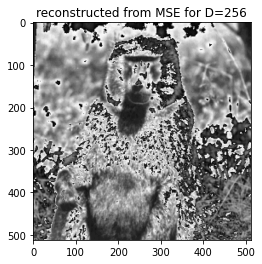

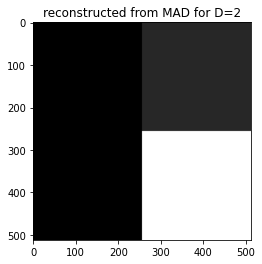

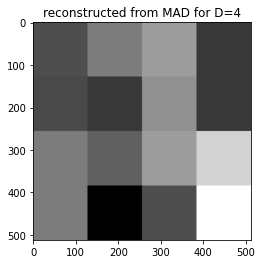

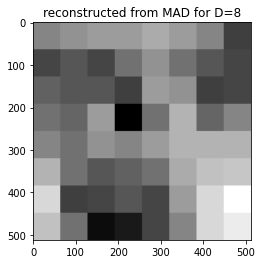

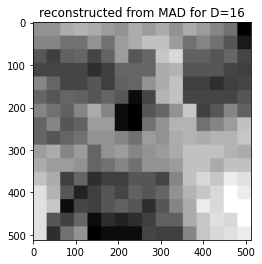

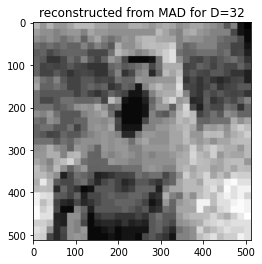

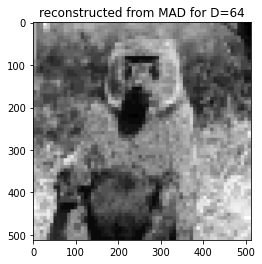

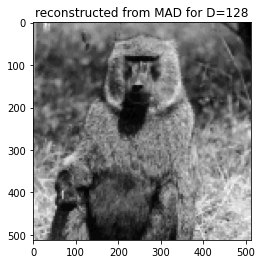

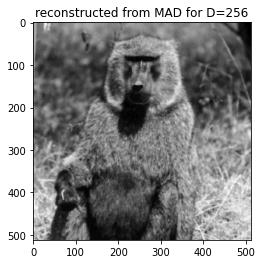

In [46]:
#@title
#show reconstructed from MSE subsampling
for b in range(1,9):
  plt.title(f'reconstructed from MSE for D={2**b}')
  plt.imshow(reconstructed_images_mse[b-1], cmap='gray')
  plt.show()

#show reconstructed from MAD subsampling
for b in range(1,9):
  plt.title(f'reconstructed from MAD for D={2**b}')
  plt.imshow(reconstructed_images_mad[b-1], cmap='gray')
  plt.show()


##3. Discussion about how the integer sub-sampling factor D affects the result
As we can see in the MSE and the MAD pictures for different D values, Higher D values result with a picture similar to the origin. The MAD seems to converge quicker (similar image is shown earlier in D)

#Q3  Solving the L^p problem using the L^2 solution
##1.
Generelised pseudo Code of the approximation L^p problem on 2D domain:

pseudo-code:
1. for i in range(N):
2.  for j in range(N):
3.   define f_i,j(x1,x2) = f((i-0.5)/N, (j-0.5)/N)
4.do:
5.----define w_i,j(x1,x2) = min(1/eps , abs(f(x1,x2) - f_i,j(x1,x2))^p-2)
6.----define f_next_i,j = (integral(w_i,j(x1,x2) * f(x1,x2)))/(integral(w_i,j(x1,x2))
7.----flag = (f_i,j(x1,x2) is equal f_next_i,j)
8.----define f_i,j =  f_next_i,j
9.while (not flag)

return f_i,j


##2. Implementation of the algorithm.


In [51]:
#@title
def mpe(image,qimage,p):
  """
  Return the mean L-p error.
  """
  x_size=image.shape[0]
  y_size=image.shape[1]
  return sum(sum(abs(image-qimage)**p))/(x_size*y_size)

def calc_lp_solver_image(image, n, p, epsilon,delta=0.001):
  """
  Given:
    image- the original image,
    n- define nXn grid size,
    p- defines Lp
    epsilon- 1/epsilon defines maximum value of weight function.
    delta- stop condition
  Return the approximated Lp solver image.
  """
  interval_size = int(image.shape[0] / n)

  # create initial image_solver
  image_solver = np.zeros(image.shape)
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      row_ind = int(int(i/interval_size) * interval_size)
      col_ind = int(int(j/interval_size) * interval_size)
      image_solver[i][j] = image[row_ind][col_ind]

  #Improvement itterations:    
  flag = False
  while not flag:
    # calculate new weight function:
    w = np.zeros(image.shape)
    for i in range(image.shape[0]):
      for j in range(image.shape[1]):
        max_val = 1/epsilon
        w_tag = (np.abs(image[i][j] - image_solver[i][j]) ** (p-2)) if p>=2 or (image[i][j] != image_solver[i][j]) else max_val+1
        w[i][j] = min(max_val, w_tag)

    # calculate new image_solver
    image_solver_next = np.zeros(image.shape)
    top_integrand = w*image
    for i in range(n):
      for j in range(n):
        ri = i*interval_size
        ci = j*interval_size
        rf = ri + interval_size
        cf = ci + interval_size
        w_sum = np.sum(w[ri:rf,ci:cf])
        const_value = (np.sum(top_integrand[ri:rf,ci:cf]) / w_sum) if w_sum != 0 else image_solver[ri][ci]
        image_solver_next[ri:rf,ci:cf] = const_value
    
    mpe_next=mpe(image,image_solver_next,p)
    mpe_prev=mpe(image,image_solver,p)
    mpe_diff=mpe_prev-mpe_next
    flag = mpe_diff/mpe_next<delta
    image_solver = image_solver_next

  return image_solver

#3. Implementation of L^1 ecxact solution.

In [52]:
#@title
def calc_l1_problem(image, n):
  """
  Given:
    image- the original image,
    n- define nXn grid size,
  Return the optimal L1 solver image.
  """
  interval_size = int(image.shape[0] / n)
  image_solver = np.zeros(image.shape)
  for i in range(n):
    for j in range(n):
      ri = i*interval_size
      ci = j*interval_size
      rf = ri + interval_size
      cf = ci + interval_size
      image_solver[ri:rf,ci:cf] = np.median(image[ri:rf,ci:cf])
  return image_solver     

#4. Comparing L1 exact solution with the Lp approximated algorithm (for p=1)

As we can see the exact solution gives clearer image than the approx solution.
As epsilon changes the approx solution changes as well.
for some Lp's higher epsilon values get closer image to the exact solution.

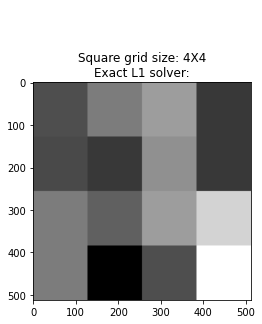

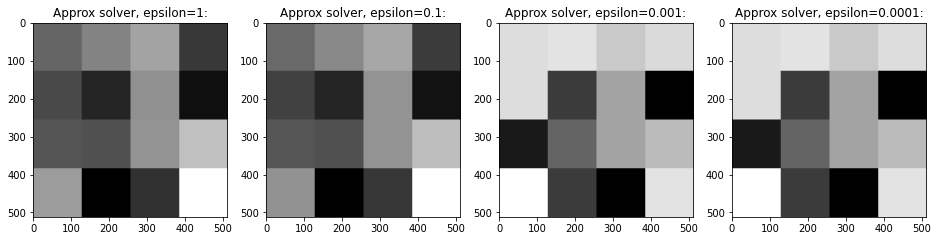

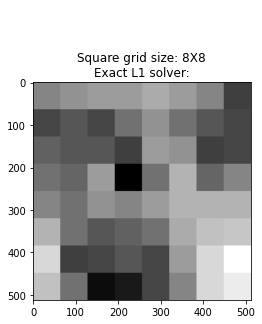

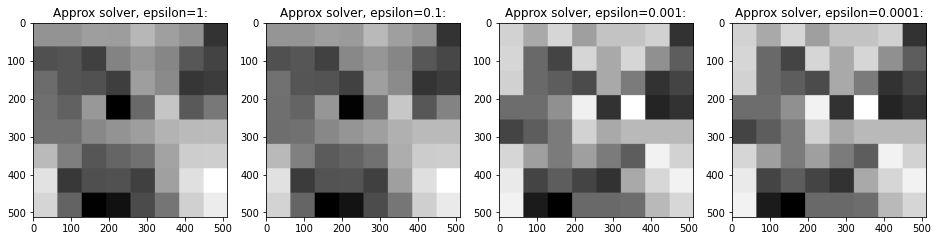

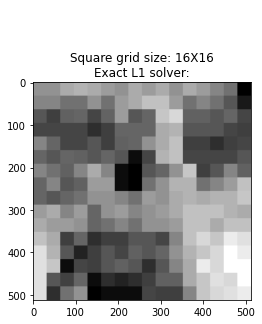

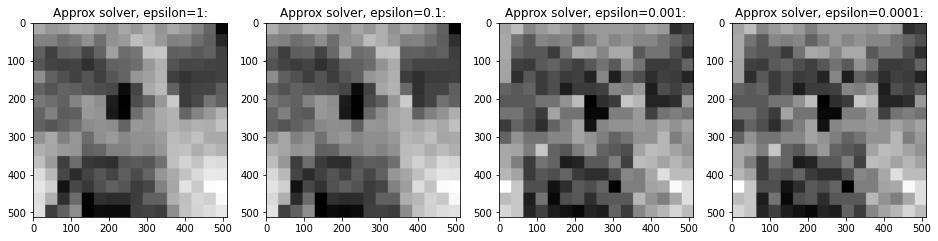

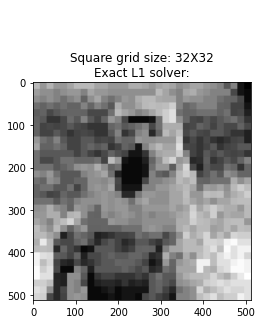

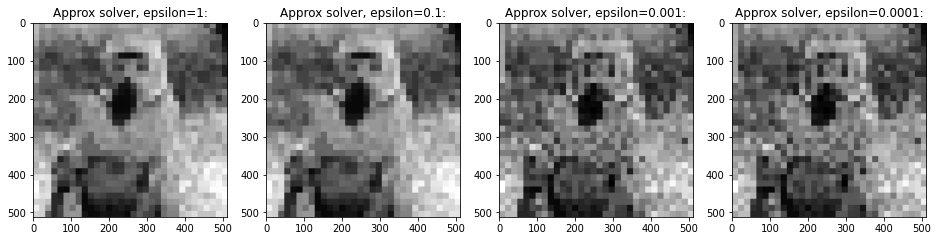

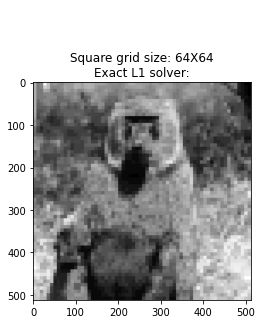

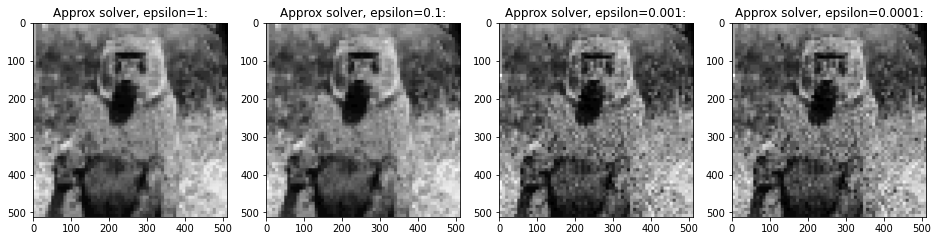

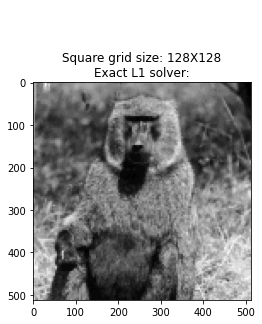

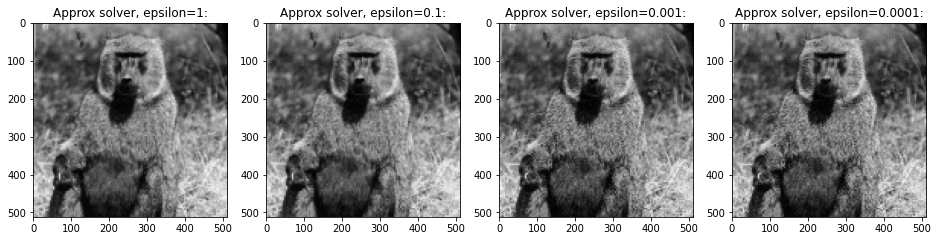

In [53]:
#@title
for n in [4,8,16,32,64,128]:
  l1_solver_exact = calc_l1_problem(image, n)
  fig1, ax1 = plt.subplots(1, 1, figsize=(4,4))
  ax1.imshow(l1_solver_exact, cmap='gray')
  ax1.set_title(f'\n\n\nSquare grid size: {n}X{n}\nExact L1 solver:')
  fig1.show()

  fig2, axs = plt.subplots(1, 4, figsize=(16,16))

  for i,epsilon in enumerate([1, 0.1, 0.001, 0.0001]):
    l1_solver_aprox = calc_lp_solver_image(image, n, 1, epsilon, 0.01)
    axs[i].imshow(l1_solver_aprox, cmap='gray')
    axs[i].set_title(f'Approx solver, epsilon={epsilon}:')


#5. Running the algorithm on p=3/2 and p=4.
We can see that aproximated image of L-1.5 gives clearer result compared to L4, with the same image size and epsilon.

We chose here image size of 32X32 and epsilon=0.001

aprox L-1.5 solver:


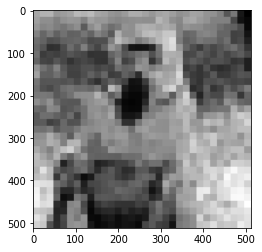

aprox L-4 solver:


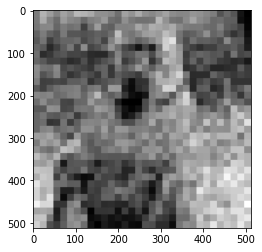

In [56]:
#@title
# Run on different ps:
ps = [3/2, 4]
solver_aprox = []
for p in ps:
  solver_aprox.append(calc_lp_solver_image(image, 32, p, 0.001))
  print(f'aprox L-{p} solver:')
  plt.imshow(solver_aprox[-1], cmap='gray')
  plt.show()